# Project A1: Advanced OS and CPU Feature Exploration
## 1. Introduction

The goal of this project is to investigate OS/CPU features. I am going to explore how asynchronous I/O changes the performance behavior of storage systems, and how this change interacts with operating system scheduling, memory locality, and CPU microarchitecture.

## 2. Methodology
### 2.1 Experimental Environment
CPU: AMD Ryzen 5 7600X | 4691.105Mhz

Cache hierarchy:

L1d: 32 KB per core × 6

L1i: 32 KB per core × 6

L2: 1 MB per core × 6

L3: 32 MB shared

OS: Ubuntu 24.04.3 LTS

gcc: gcc (Ubuntu 13.3.0-6ubuntu2~24.04) 13.3.0

### 2.2 Setup & Measurement Method

First we benchmark synchronous blocking I/O (psync) and asynchronous I/O (io_uring) on the same storage device to understand how different I/O models affect throughput (IOPS) and tail latency (p99) as the level of I/O concurrency increases using fio.

Workload:

Access pattern: randread

Block size: 4 KB

I/O mode: Direct I/O

Time duration: 30 seconds

First create a large file using fallocate


In [ ]:
fallocate -l 4G test.dat

Run: 

In [ ]:
chmod +x baseline.sh
./baseline.sh test.dat

bash extract_csv.sh results_baseline baseline.csv

python3 plot_baseline.py

Then I am going to test how CPU affinity influences the performance of synchronous and asynchronous I/O under a fixed I/O concurrency. 

Workload:

Access pattern: randread

Block size: 4 KB

I/O mode: Direct I/O

Time duration: 30 seconds

Concurrency: 16

SMT-on: 0-11
SMT-off: 0-5

Run:

In [ ]:
chmod +x cpu_affinity.sh
./cpu_affinity.sh test.dat

bash extract_affinity_c16.sh results_affinity_c16 affinity.csv

python3 plot_affinity.py

Next step is to evaluate the impact of Simultaneous Multithreading (SMT) on synchronous and asynchronous I/O performance. SMT exposes two logical CPUs per physical core, which can improve utilization but may also introduce contention for shared execution resources.

Run:

In [ ]:
chmod +x SMT.sh
./SMT.sh test.dat

bash extract_smt_c16.sh results_smt_c16 smt.csv

python3 plot_smt.py

In the final experiment, I am going to test  how Transparent Huge Pages vs regular 4KB pages affect direct I/O performance.

Workload:

Access pattern: randread

Block size: 128 KB

I/O mode: 0

Time duration: 30 seconds

Concurrency: 16

Page size (baseline): 4 KB page

Page size (huge pages): 2 MB page

Run:

chmod +x thp.sh
./thp.sh test.dat

bash extract_thp_c16.sh results_thp_c16 thp.csv

python3 plot_htp.py

# 3. Results
## 3.1 Synch / Async I/O under different concurrency

| 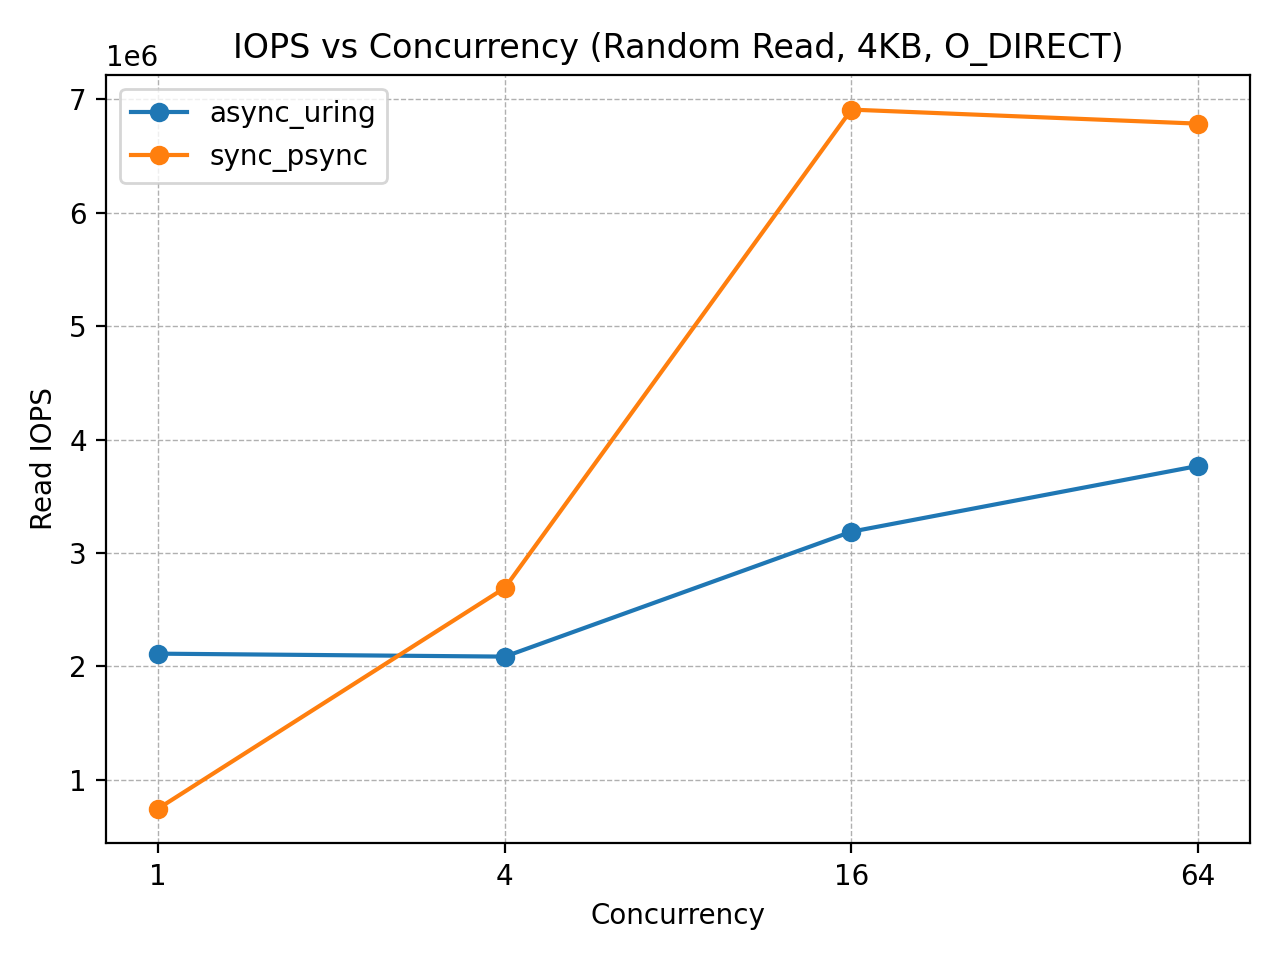 | 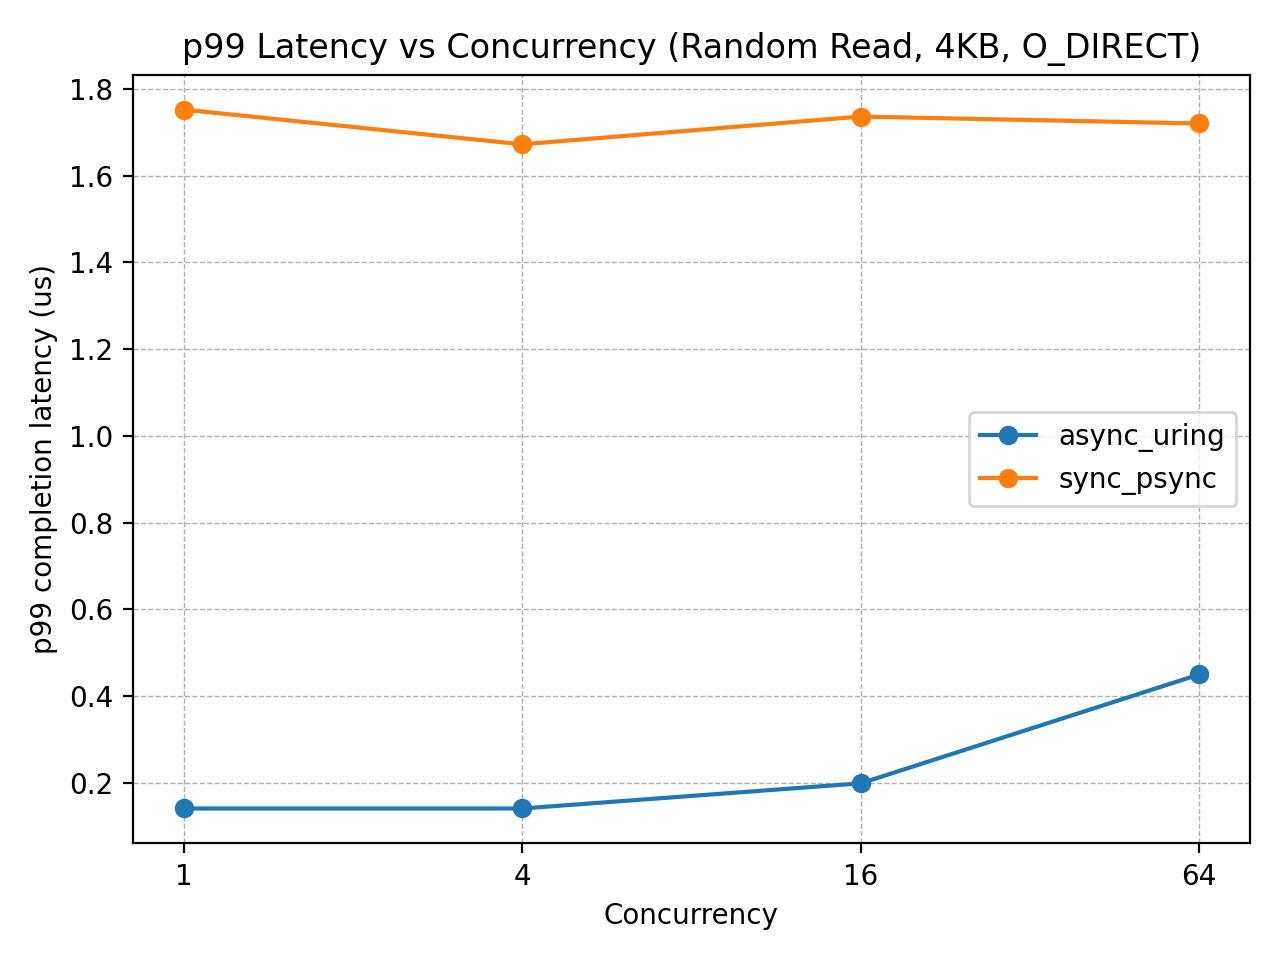|
|:----------------------------------------------------:|:----------------------------------:|

As shown in Figure 1, both synchronous and asynchronous I/O exhibit increasing throughput as concurrency rises. Synchronous I/O scales aggressively from low to medium concurrency, reaching near-peak throughput at a concurrency of 16. Synchronous I/O can exploit multiple CPU cores to issue concurrent requests and fully saturate the storage device. Asynchronous I/O shows a more gradual increase in IOPS. Although io_uring maintains multiple in-flight requests via queue depth, its throughput grows more conservatively and remains below that of synchronous I/O.

In Figure 2, Synchronous I/O maintains a relatively stable p99 completion latency of approximately 1.7 µs across all concurrency levels. In contrast, asynchronous I/O achieves significantly lower p99 latency at low concurrency, reflecting its non-blocking execution model and reduced context-switch overhead.

## 3.2 CPU affinity


| 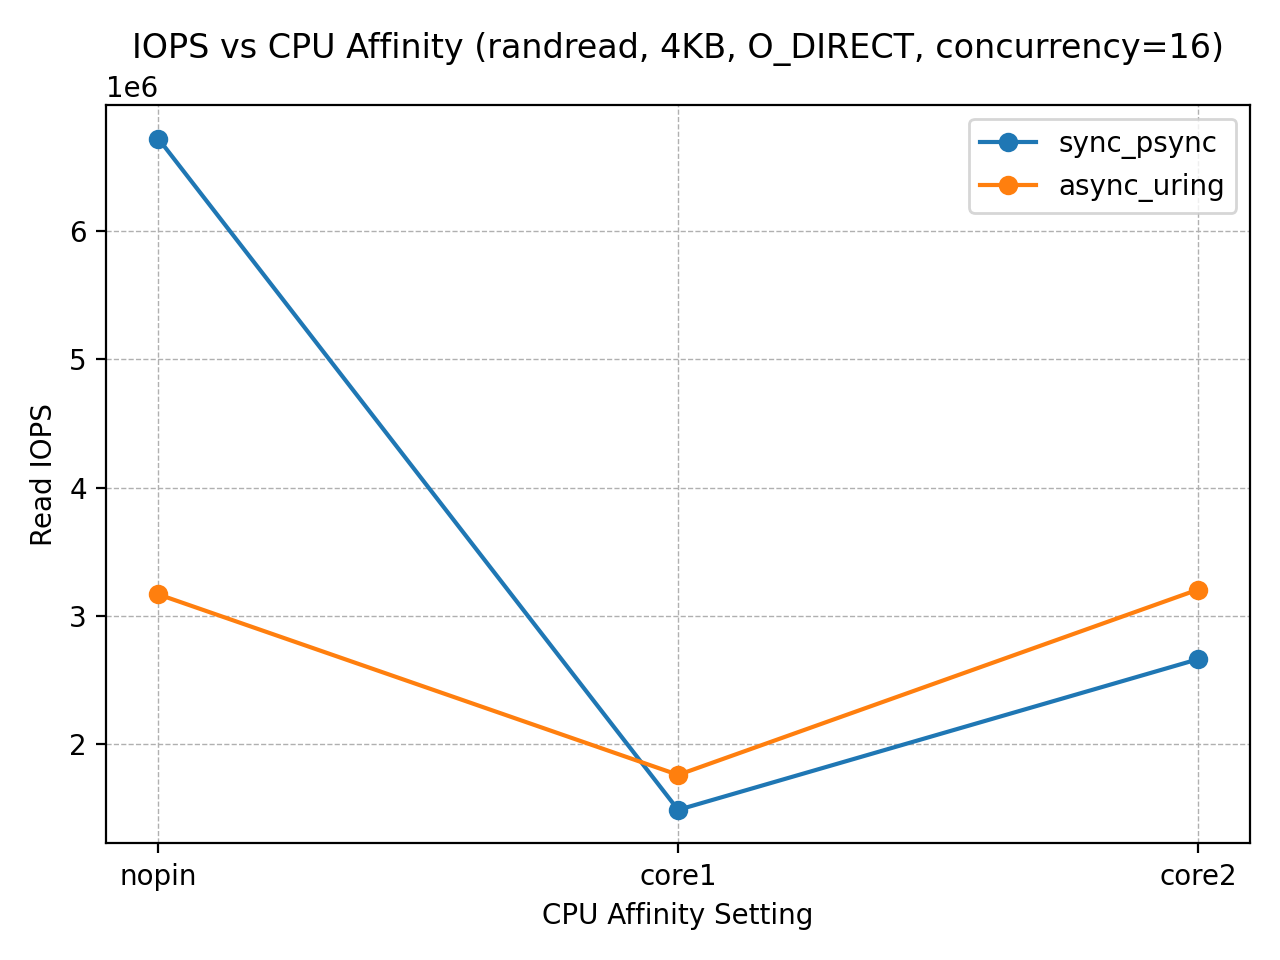 | 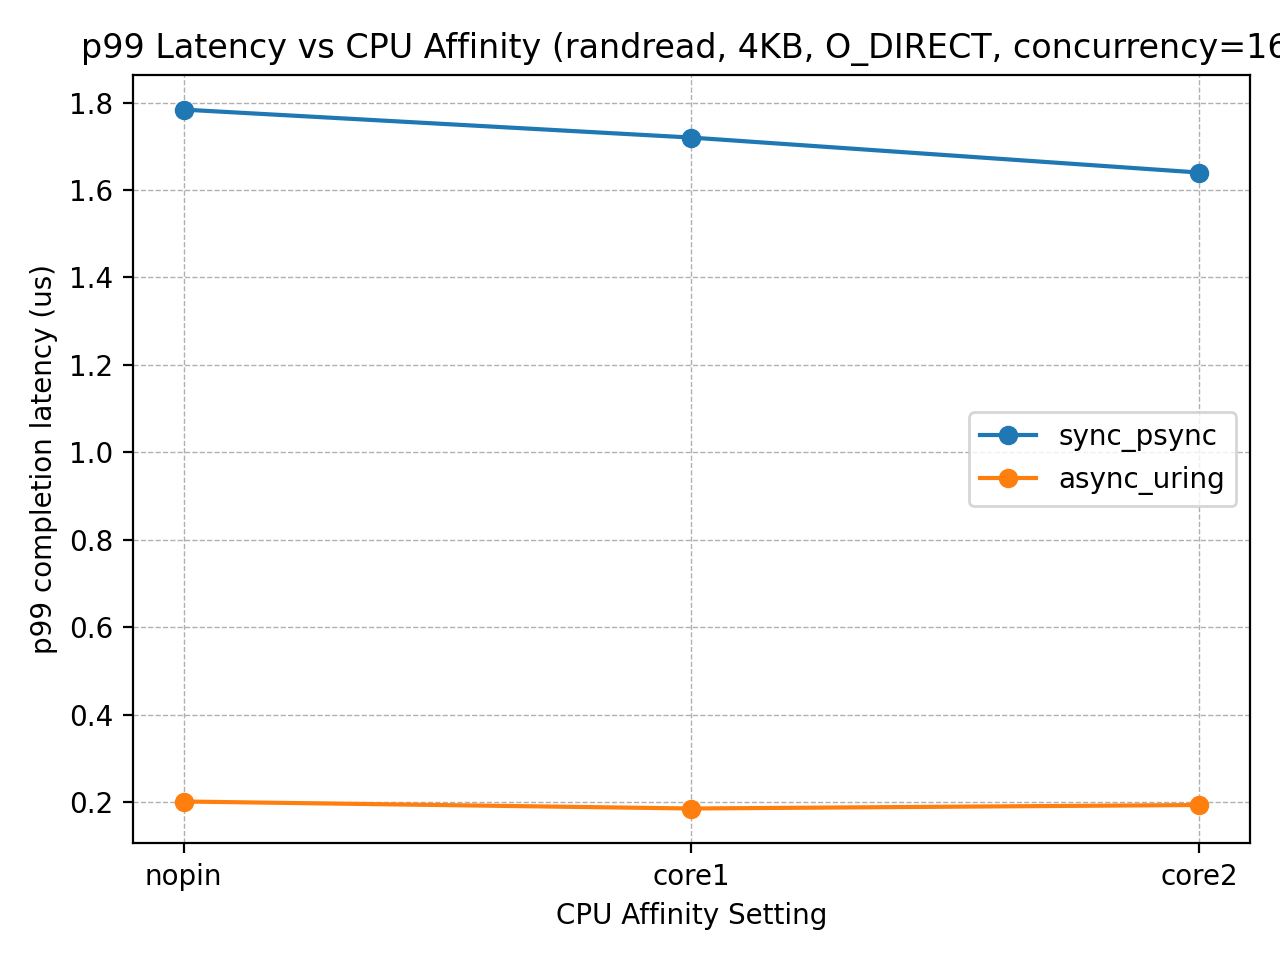|
|:----------------------------------------------------:|:----------------------------------:|

In Figure 1, Without CPU pinning, synchronous I/O achieves the highest IOPS by exploiting thread-level parallelism across many cores. When execution is restricted to a single physical core, synchronous I/O suffers a sharp throughput drop due to severe thread contention and scheduling overhead. As more CPU cores become available synchronous throughput partially recovers. In contrast, asynchronous I/O exhibits a more moderate throughput degradation under CPU restriction and recovers more quickly as CPU resources increase, indicating lower sensitivity to CPU core availability.

In Figure 2, Synchronous I/O consistently shows higher p99 latency, reflecting its reliance on blocking threads and frequent wake-ups that are sensitive to CPU scheduling. As CPU resources increase, its tail latency decreases slightly but remains elevated. Asynchronous I/O maintains significantly lower and more stable p99 latency across all affinity settings, demonstrating that its non-blocking, queue-based execution model is more resilient to CPU resource constraints.

## 3.3 SMT




| 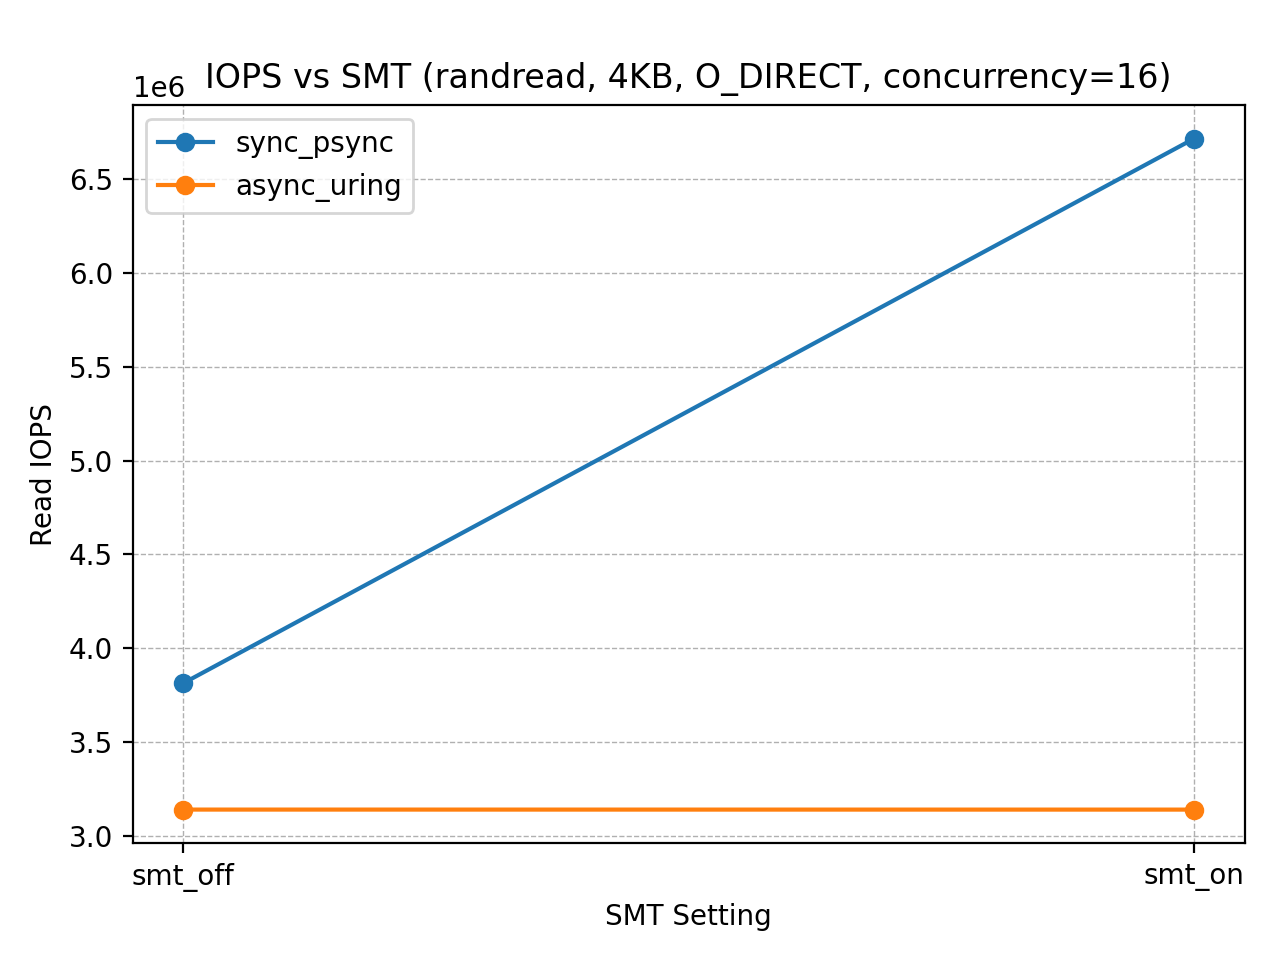 | 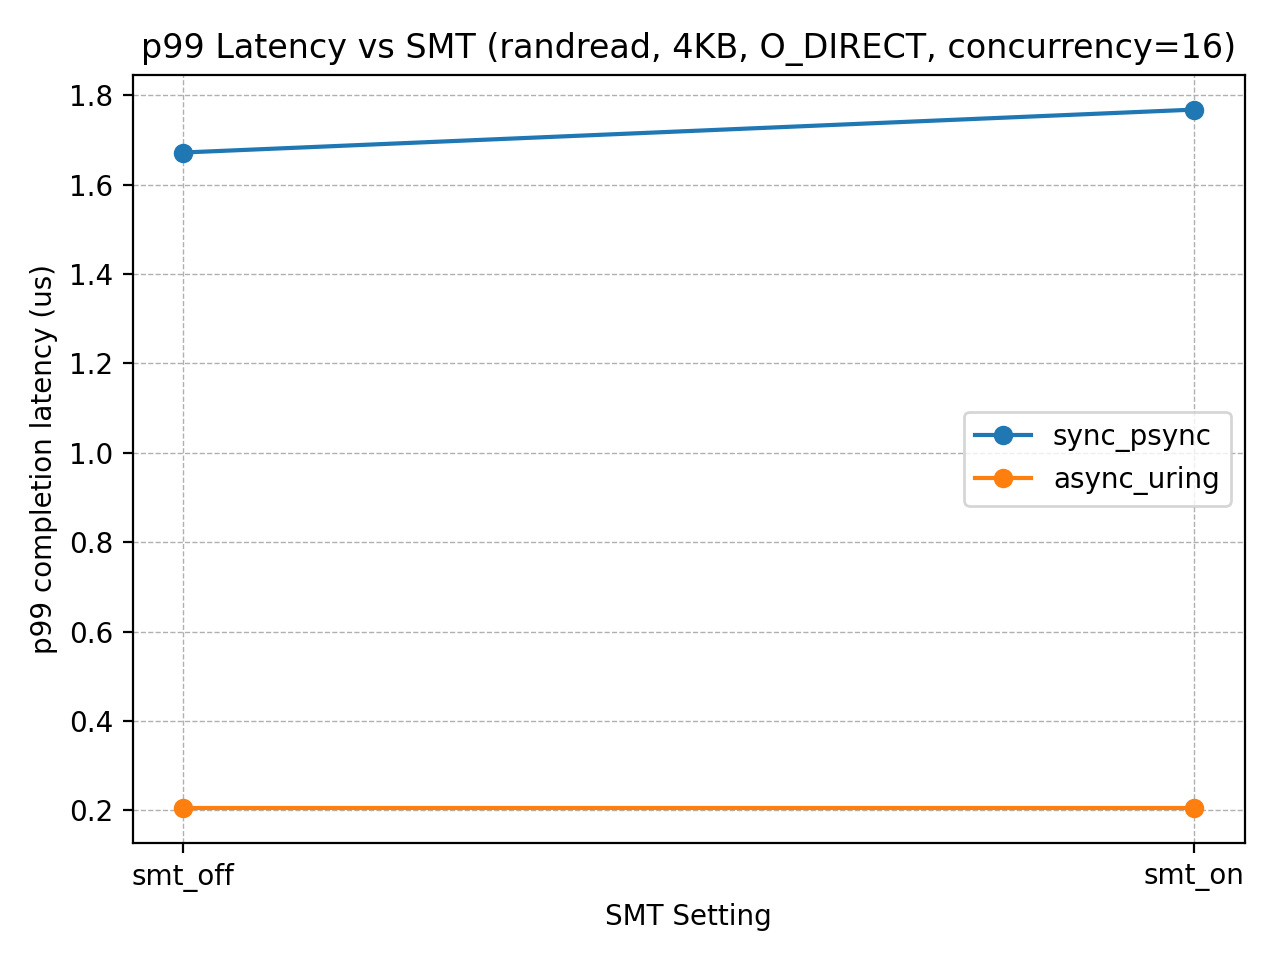 |
|:----------------------------------------------------:|:----------------------------------:|
|                                      |                                  |




Enabling SMT significantly improves throughput for synchronous I/O, increasing IOPS from about 3.8M to 6.7M by providing additional hardware threads to hide blocking and scheduling overhead. However, this throughput gain comes with a slight increase in p99 latency due to increased contention for shared core resources. In contrast, asynchronous I/O shows nearly identical throughput and tail latency under both SMT-on and SMT-off configurations, indicating that its queue-based, non-blocking execution model is largely insensitive to SMT. Overall, SMT primarily benefits synchronous I/O, while asynchronous I/O remains stable regardless of hardware threading.

## 3.4 THP

| 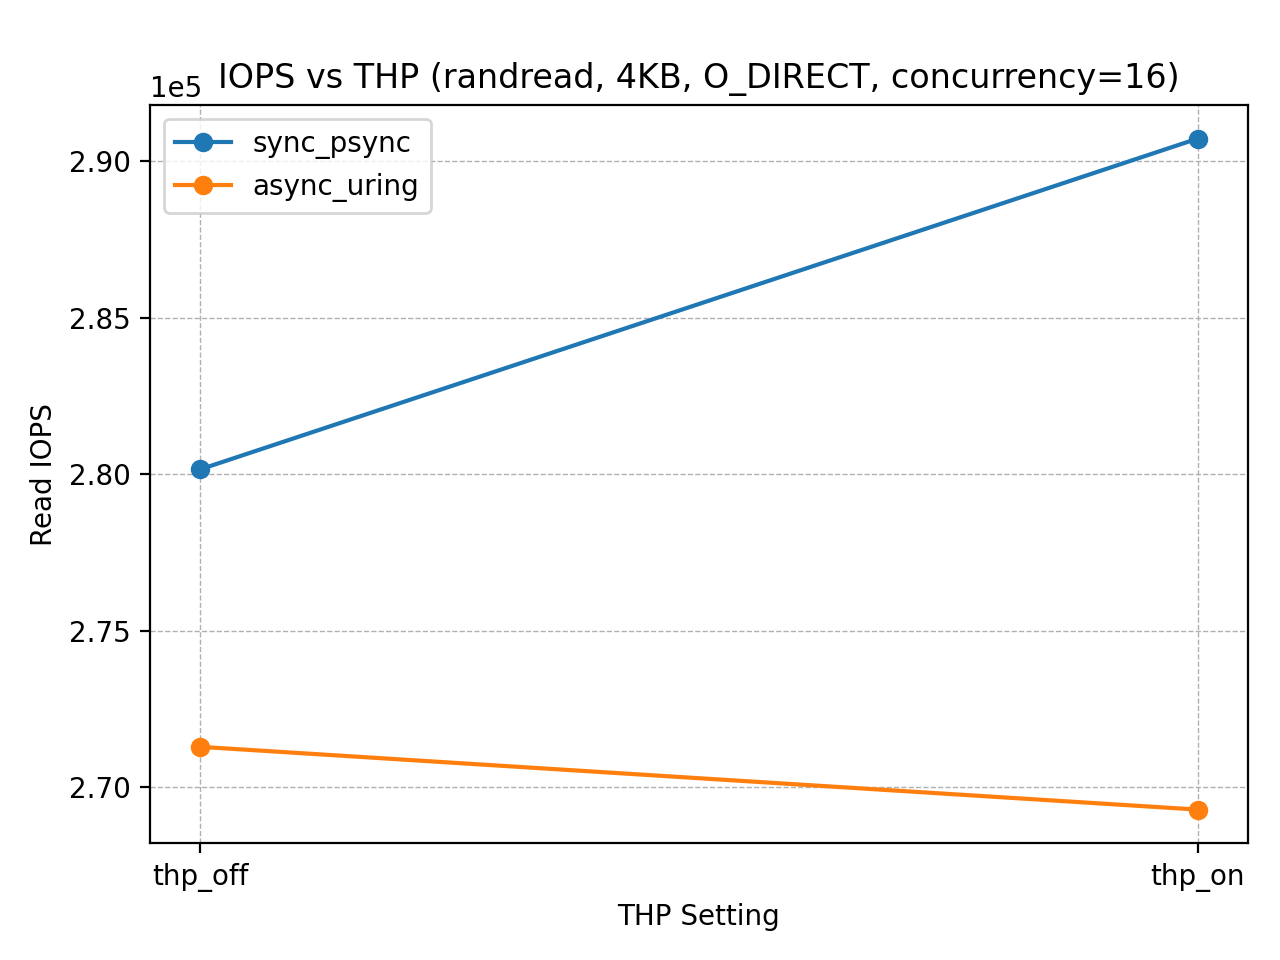| 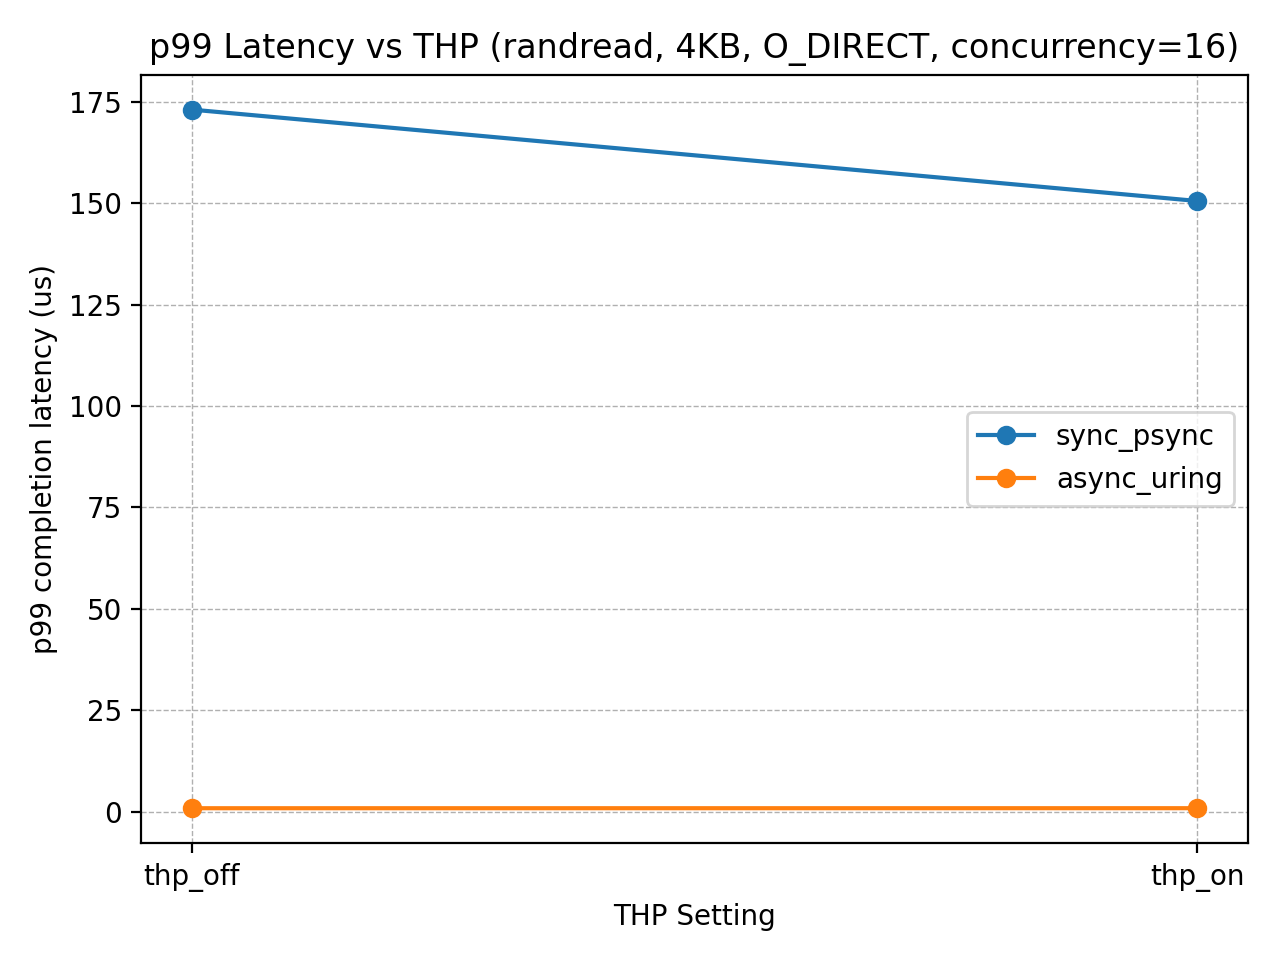|
|:----------------------------------------------------:|:----------------------------------:|

Enabling Transparent Huge Pages (THP) improves the performance of synchronous buffered random reads, increasing IOPS and reducing p99 latency. This indicates that THP effectively reduces page table and TLB overhead when page cache is heavily involved. In contrast, asynchronous I/O performance remains largely unchanged: its throughput is stable and its p99 completion latency stays near zero, as requests are served immediately from the page cache and latency is hidden by the asynchronous execution model. Overall, THP primarily benefits synchronous, while asynchronous I/O is mostly insensitive to page size optimizations.